In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
%matplotlib inline

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [4]:
# Удалим столбцы 'id','name','host_id','host_name','last_review' как неинформативные для цены
df.drop(['id','name','host_id','host_name','last_review'],axis=1,inplace=True)
# Посчитаем количество пропусков
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
# Пропущенные значения для reviews_per_month заменили нулями
df.loc[df['reviews_per_month'].isnull(),'reviews_per_month']=0

In [6]:
# Удалим строки с нулевой ценой
df=df[df['price']>0]

In [7]:
# Обновим индексы
df.reset_index(drop=True,inplace=True)

In [8]:
# Введем столбец center_distance - удаленность от центра Нью-Йорка
df['center_distance']=np.sqrt((df['latitude']-40.7)**2+(df['longitude']+74)**2)

In [9]:
# Удалим ненужные более колонки географических координат жилья
df.drop(['latitude','longitude'],axis=1,inplace=True)

In [10]:
# Посмотрим на результат
df.head(10)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,0.059336
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,0.056022
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365,0.123535
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,0.042896
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,0.113320
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,0.053828
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,0.40,1,0,0.045953
7,Manhattan,Hell's Kitchen,Private room,79,2,430,3.47,1,220,0.066617
8,Manhattan,Upper West Side,Private room,79,2,118,0.99,1,0,0.106925
9,Manhattan,Chinatown,Entire home/apt,150,1,160,1.33,4,188,0.016534


In [11]:
# Посмотрим базовые статистики. Видим, что есть выбросы данных 
df.describe(percentiles=[0.25, 0.75, 0.99,0.999])

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498,0.077284
std,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271,0.047507
min,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.003709
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.044222
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,0.064816
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,0.100626
99%,799.000000,45.000000,214.000000,6.800000,232.000000,365.000000,0.236759
99.9%,3000.000000,354.702000,380.585000,11.161170,327.000000,365.000000,0.271723
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,0.313190


In [12]:
# Удалим строки со значением minimum_nights, большей 354
# (то есть удалим выброс данных во второй колонке)
df=df[df["minimum_nights"]<355]


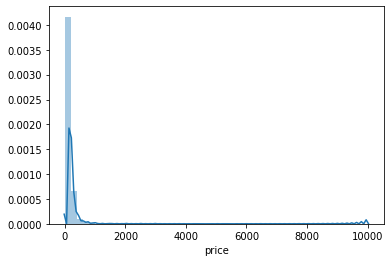

In [13]:
# Функция распределения цены. Виден большой диапазон цен и неравномерное распределение предложений по ценам. 
# Возможно имеет смысл разбить предложения жилья на 2 категории - "бюджетные"и "ВИП" предложения и по каждой 
# делать прогноз.
sns_plot = sns.distplot(df['price'])

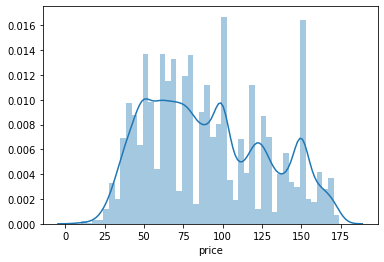

In [14]:
# Выделим "бюджетную" категорию по третьей квартили для цены
# и далее будем ее исследовать.
df=df[df["price"]<175]
sns_plot = sns.distplot(df['price'])

In [15]:
# Найдем попарную корреляцию числовых признаков
Corr=df.corr()
Corr
# Видим, что цена слабо коррелирует с остальными признаками.
# Наибольшая зависимость наблюдается от расстояния до центра.

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
price,1.000000,0.014341,0.030370,-0.021428,0.039994,-0.007176,-0.250592
minimum_nights,0.014341,1.000000,-0.105947,-0.166516,0.202507,0.154264,-0.062778
number_of_reviews,0.030370,-0.105947,1.000000,0.603102,-0.049094,0.197398,0.043517
reviews_per_month,-0.021428,-0.166516,0.603102,1.000000,-0.052453,0.179811,0.142291
calculated_host_listings_count,0.039994,0.202507,-0.049094,-0.052453,1.000000,0.198115,-0.039960
availability_365,-0.007176,0.154264,0.197398,0.179811,0.198115,1.000000,0.167390
center_distance,-0.250592,-0.062778,0.043517,0.142291,-0.039960,0.167390,1.000000


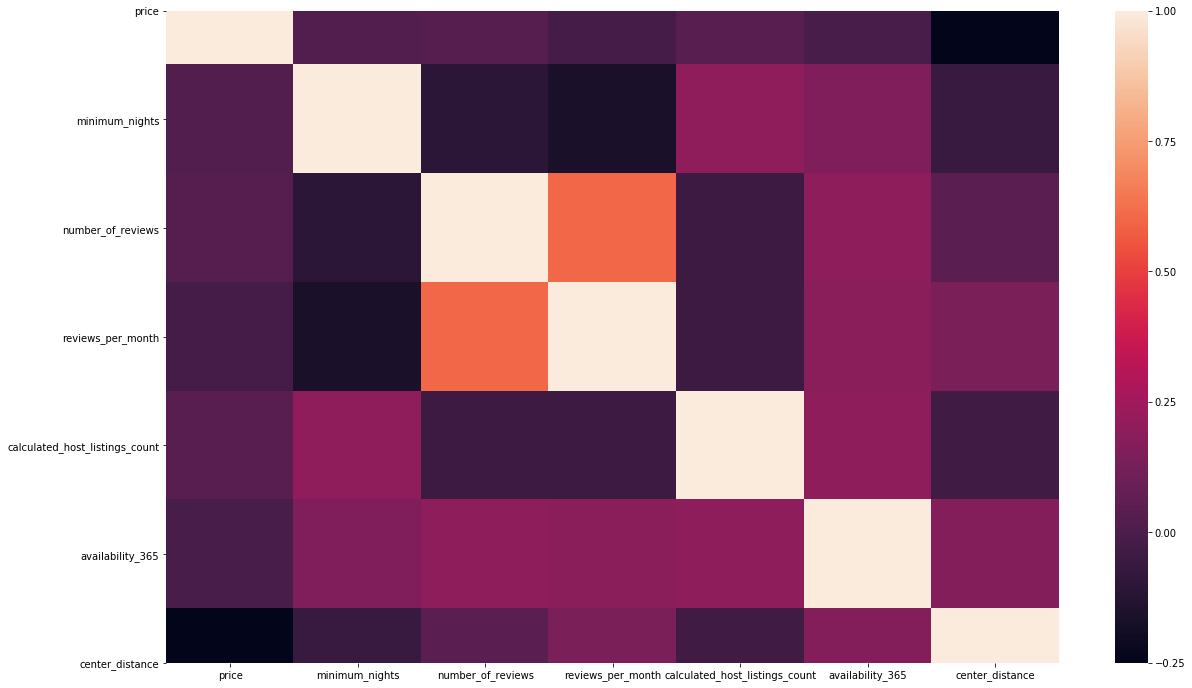

In [16]:
#Построим heatmap. Видим то же самое,т.е. цена слабо с остальными признаками.
plt.figure(figsize=(20,12))
sns.heatmap(Corr)

In [17]:
# Закодируем категориальные данные
dfd=pd.get_dummies(df)

In [18]:
dfd.head(10)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21,6,365,0.059336,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,150,3,0,0.00,1,365,0.123535,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,89,1,270,4.64,1,194,0.042896,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,80,10,9,0.10,1,0,0.113320,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,60,45,49,0.40,1,0,0.045953,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,79,2,430,3.47,1,220,0.066617,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8,79,2,118,0.99,1,0,0.106925,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,150,1,160,1.33,4,188,0.016534,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10,135,5,53,0.43,1,6,0.108792,0,0,1,...,0,0,0,0,0,0,0,1,0,0
11,85,2,188,1.50,1,39,0.061807,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# Найдем попарную корреляцию всех данных
Corrd=dfd.corr()

In [20]:
# Выбираем признаки, у которых корреляция с ценой больше 0.15 по
# абсолютной величине
for j in Corrd.index[abs(Corrd['price']) > 0.15]:
       print (j, Corrd['price'][Corrd.index == j].values[0])

price 1.0
center_distance -0.2505916922968879
neighbourhood_group_Manhattan 0.2673799812901363
neighbourhood_group_Queens -0.1519982948118608
room_type_Entire home/apt 0.6138841221453706
room_type_Private room -0.5449014353206257
room_type_Shared room -0.17441402069901005


In [21]:
# Выделим их в качестве объясняющих переменных для регрессии
X=dfd[['center_distance','neighbourhood_group_Manhattan','neighbourhood_group_Queens','room_type_Entire home/apt','room_type_Private room','room_type_Shared room']]

In [22]:
# Зависимая переменная - цена
y=dfd['price']

In [23]:
# Разбиваем выборку на обучающую 70% и тестовую 30% 
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42)

In [24]:
# Нормализуем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Обучаем модель линейной регессии
lr = LinearRegression().fit(X_train, y_train)

In [26]:
#Оценим качество модели с помощью метода score, который для регрессионных моделей возвращает значение 
#коэффициента детерминации R^2. Видим, что он невелик, значит связь между переменными слабая.
lr_train=lr.score(X_train, y_train)
lr_train

0.48112821069988143

In [27]:
# Оценим качество модели и на тестовых выборках
lr_test=lr.score(X_test, y_test)
lr_test
# Здесь коэфициент детерминации почти такой же, как на обучающих данных.


0.4789893255067593

In [28]:
# Выведем список коэффициентов модели линейно регрессии. Видим очень большие коэффициенты при 4, 5 и 6 признаках.
# Это скорее всего означает, что матрица X^T*X (обратная к которой используется при вычислении коэффициентов
# линейной регрессии в МНК) имеет определитель близкий к нулю. Попробуем сделать регуляризацию.
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))

lr.coef_: [-1.65801120e+02  1.93742292e+01  5.81208093e+00 -8.98520507e+13
 -8.98520507e+13 -8.98520507e+13]
lr.intercept_: 89852050723672.53


In [29]:
#Гребневая регрессия
ridge = Ridge(alpha=0.1).fit(X_train, y_train)

In [30]:
# Вычисляем коэффициент детерминации на обучающей
ridge_train=ridge.score(X_train, y_train)
ridge_train

0.481128129202157

In [31]:
# и на тестовых выборках
ridge_test=ridge.score(X_test, y_test)
ridge_test
# Они примерно совпадают и мало отличаются от простой линейной регрессии. Не видно улучшения.

0.47898404598625477

In [32]:
# Зато коэффициенты гребневой регрессии значительно меньше, чем у линейной.
print("ridge.coef_: {}".format(ridge.coef_))
print("ridge.intercept_: {}".format(ridge.intercept_))

ridge.coef_: [-165.33006131   19.35511179    5.78018051   36.63229128   -7.88574802
  -28.7465434 ]
ridge.intercept_: 87.96696581214924


In [33]:
# Попробуем регуляризацию лассо. 
lasso = Lasso(alpha=0.1).fit(X_train, y_train)

In [34]:
# Оценим регуляризацию лассо. Картина почти такая же, как при гребневой регрессии.
lasso_train=lasso.score(X_train, y_train)
lasso_train

0.4763357359330493

In [35]:
lasso_test=lasso.score(X_test, y_test)
lasso_test

0.4744354303777515

In [36]:
# Коэффициент при одном признаке занулился
print("Количество использованных признаков: {}".format(np.sum(lasso.coef_ != 0)))

Количество использованных признаков: 5


In [37]:
print("lasso.coef_: {}".format(lasso.coef_))
print("lasso.intercept_: {}".format(lasso.intercept_))

lasso.coef_: [-107.93782631   17.9918361     0.70460686   44.59681397    0.
  -17.49399085]
lasso.intercept_: 76.35339332039459


In [52]:
# Применим Elastic Net, чтобы объединить штрафы  гребневой регрессии и лассо. 
elastic = ElasticNet(alpha=0.01).fit(X_train, y_train)

In [53]:
# Меняя параметр alpha, можно заметить, что чем он ближе к 0, тем коэффициент Детерминации больше. Остановимся на 
# alpha = 0.01, т.е. сделаем Elastic Net ближе к гребневой регрессии, чем к лассо.
elastic_train=elastic.score(X_train, y_train)
elastic_train

0.4612008088035996

In [54]:
# Оценим качество Elastic Net на тестовой выборке. Картина всё та же.
elastic_test=elastic.score(X_test, y_test)
elastic_test

0.4596554511215034

In [55]:
#посмотрим на коэффициенты
print("elastic.coef_: {}".format(elastic.coef_))
print("elastic.intercept_: {}".format(elastic.intercept_))

elastic.coef_: [-44.34742201  17.52655215  -2.54697187  35.73295801  -8.97325173
 -25.54597532]
elastic.intercept_: 80.56502080063039


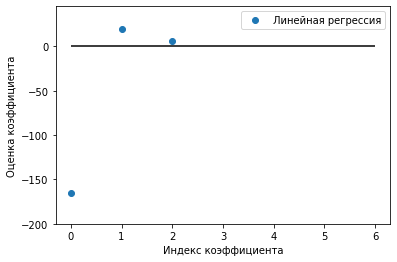

In [42]:
#Визуализируем коэффициенты линейной регрессии. Видим, что 3 коэффициента не нарисованы, т.к. очень большие
plt.plot(lr.coef_, 'o', label="Линейная регрессия")
plt.xlabel("Индекс коэффициента")
plt.ylabel("Оценка коэффициента")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-200, 45)
plt.legend()

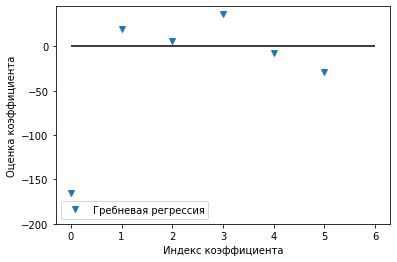

In [43]:
#Визуализируем коэффициенты гребневой регрессии. Видим, что все коэффициенты влезли на рисунок, т.е. стали меньше,
# но первый коэффициент (при center_distance) по сравнениию с другими велик по модулю.
plt.plot(ridge.coef_, 'v', label="Гребневая регрессия")
plt.xlabel("Индекс коэффициента")
plt.ylabel("Оценка коэффициента")
plt.hlines(0, 0, len(ridge.coef_))
plt.ylim(-200, 45)
plt.legend()

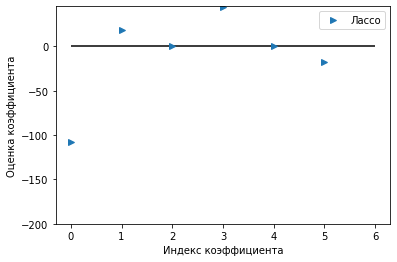

In [44]:
#Визуализируем коэффициенты регрессии лассо. Видим, что коэффициенты уже меньше разбросаны, чем у первых двух регрессий
plt.plot(lasso.coef_, '>', label="Лассо")
plt.xlabel("Индекс коэффициента")
plt.ylabel("Оценка коэффициента")
plt.hlines(0, 0, len(lasso.coef_))
plt.ylim(-200, 45)
plt.legend()

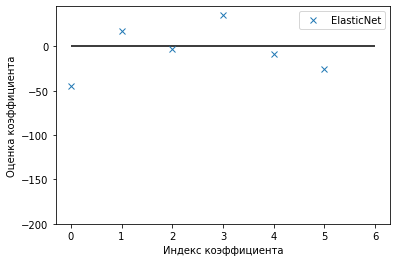

In [57]:
#Визуализируем коэффициенты ElasticNet. Видим, что все коэффициенты по модулю ещё больше сблизились.
plt.plot(elastic.coef_, 'x', label="ElasticNet")
plt.xlabel("Индекс коэффициента")
plt.ylabel("Оценка коэффициента")
plt.hlines(0, 0, len(elastic.coef_))
plt.ylim(-200, 45)
plt.legend()